<a href="https://colab.research.google.com/github/GuidoOliveri11/tesis_MiM_Guido_Luca_Oliveri/blob/main/Guido_Oliveri_Tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-optimize
!pip install tpot
!pip install hyperopt
!pip install autogluon.tabular

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.5 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=5cbf6bad6dad660db5b5e0778bd84186cd5da934744d045c8ec8dd66c979d410
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.1/312.1 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier                                     # RF clasificacion
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold                                 # Eliminar columnas constantes o casi constantes para el VIF
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB                                              # naive bayes
from sklearn.neighbors import KNeighborsClassifier                                      # K neighbors
from sklearn.model_selection import GridSearchCV                                        # hiperparametros para RL/RF y demas algoritmos
from imblearn.over_sampling import SMOTE, RandomOverSampler                             # para la clase onboarded ajustarla
from collections import Counter                                                         # verificar distribucion onboarded despues del muestreo
from sklearn.model_selection import RandomizedSearchCV                                  # Hiperparametros RandomizedSearchCV    para RF y otros
from skopt import BayesSearchCV                                                         # Hiperparametros Bayesian Optimization para RF y otros
from skopt.space import Integer
from skopt.searchcv import BayesSearchCV
from tpot import TPOTClassifier                                                         # Configurar y ejecutar TPOT para Random Forest
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK                                   # RF hiperparametros Hyperband
from hyperopt.pyll.base import scope                                                    # RF hiperparametros Hyperband
from sklearn.model_selection import cross_val_score                                     # RF hiperparametros Hyperband
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval                       # Import space_eval
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real  # Import necessary classes for defining search spaces
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tpot import TPOTClassifier
from datetime import datetime
from autogluon.tabular import TabularPredictor

# Configuración global de semillas para reproducibilidad
import random
import os
random.seed(11)
np.random.seed(11) # numpy
os.environ['PYTHONHASHSEED'] = '11'

In [ ]:
### 1. CARGA DE DATOS ###
url = 'https://drive.google.com/uc?export=download&id=18U5tRawJ_A2Vk9x_Coye_li-Ug352Uds'
output = 'Dataset_2024_09_14.csv'
gdown.download(url, output, quiet=False)

df = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?export=download&id=18U5tRawJ_A2Vk9x_Coye_li-Ug352Uds
To: /content/Dataset_2024_09_14.csv
100%|██████████| 40.5M/40.5M [00:00<00:00, 74.9MB/s]


In [ ]:
#  No tenemos nulos en este dataset. La distribucion es 37% super heavy, 36% stable, 25% heavy y 2% onboarded. La cantidad de observaciones totales es 142.530
print("Cantidad de nulos antes de quitar nulos:", df['dif_dias_4ta_orden_a_max_seg'].isnull().sum())
print("Distribucion de max segmento alcanzado antes de quitar nulos:", df['max_lifecycle'].value_counts())

Cantidad de nulos antes de quitar nulos: 0
Distribucion de max segmento alcanzado antes de quitar nulos: max_lifecycle
4super heavy    52365
2stable         51748
3heavy          36117
1onboarded       2300
Name: count, dtype: int64


In [ ]:
#### 2. LIMPIEZA DE VALORES NULOS ###
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:  # chequear si la columna es numerica
        df.dropna(subset=[column], inplace=True)  # elimino filas con valores nulos en columnas numéricas
print(df.dtypes)


user_id                               int64
pais_registro_user                   object
dia_max_segmento_alcanzado           object
dia_semana_max_segmento_alcanzado    object
max_lifecycle                        object
dia_1er_compra                       object
dia_semana_1er_compra                object
vertical_name_1er_compra             object
is_restaurant_or_market_1ra            bool
is_pre_order_1er_compra                bool
is_pickup_1er_compra                   bool
country_1er_compra                   object
dia_2da_compra                       object
dia_semana_2da_compra                object
vertical_name_2da_compra             object
is_restaurant_or_market_2da            bool
is_pre_order_2da_compra                bool
is_pickup_2da_compra                   bool
country_2da_compra                   object
dia_3ra_compra                       object
dia_semana_3ra_compra                object
vertical_name_3ra_compra             object
is_restaurant_or_market_3ra     

In [ ]:
print("Cantidad de nulos despues de quitar nulos y antes de quitar outliers:", df['dif_dias_4ta_orden_a_max_seg'].isnull().sum())
print("Distribucion de max segmento alcanzado despues de quitar nulos y antes de quitar outliers:", df['max_lifecycle'].value_counts())

Cantidad de nulos despues de quitar nulos y antes de quitar outliers: 0
Distribucion de max segmento alcanzado despues de quitar nulos y antes de quitar outliers: max_lifecycle
4super heavy    52365
2stable         51748
3heavy          36117
1onboarded       2300
Name: count, dtype: int64


In [ ]:
### 2. LIMPIEZA DE OUTLIERS ###
factor=3 # probé con 3.75 y la cantidad post outliers para onboarded en vez de ser 288 (para factor = 3) es 620
def remove_outliers(df, col, factor):
    Q1 = df[col].quantile(0.25)  # Primer cuartil (25%)
    Q3 = df[col].quantile(0.75)  # Tercer cuartil (75%)
    IQR = Q3 - Q1  # Rango intercuartil
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# limpieza de outliers a columnas numéricas
for col in df.select_dtypes(include=[np.number]).columns:
    df = remove_outliers(df, col, factor)

In [ ]:
# Distribucion del máximo segmento alcanzado que obtenemos post sacar outliers es la siguiente: stable 37%, super heavy 37%, heavy 25% y onboarded ~1%. La cantidad de observaciones totales es 126.866
print("Cantidad de nulos post quitar nulos + outliers:", df['dif_dias_4ta_orden_a_max_seg'].isnull().sum())
print("Distribucion de max segmento alcanzado post quitar nulos + outliers:", df['max_lifecycle'].value_counts())

Cantidad de nulos post quitar nulos + outliers: 0
Distribucion de max segmento alcanzado post quitar nulos + outliers: max_lifecycle
2stable         47397
4super heavy    46861
3heavy          32320
1onboarded        288
Name: count, dtype: int64


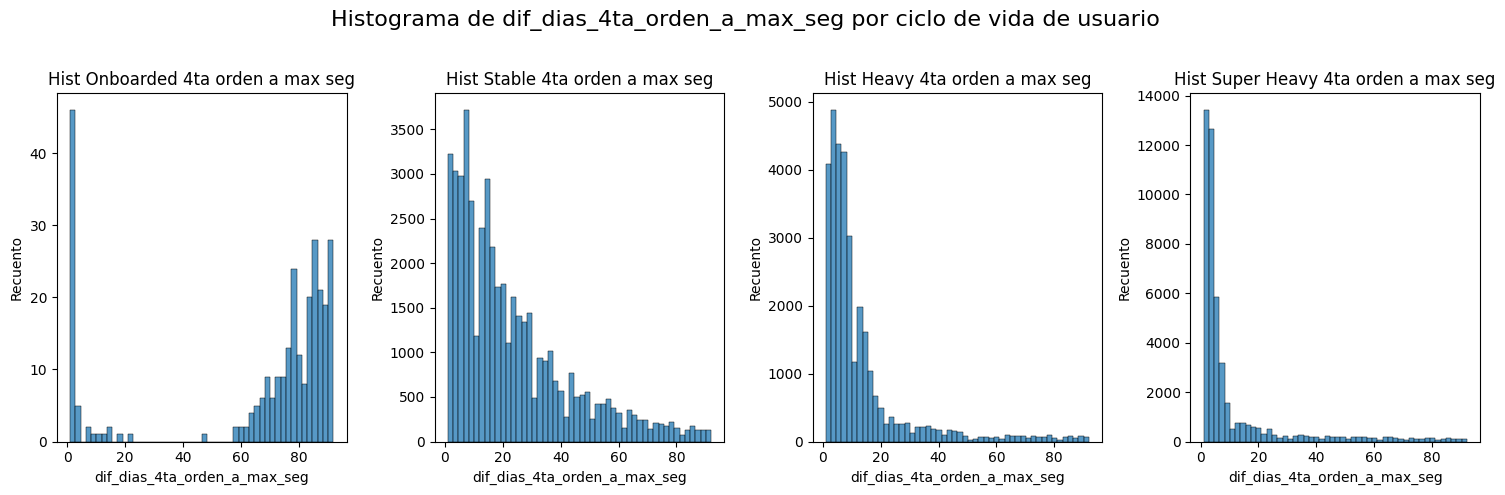

In [ ]:
### 3. ANALISIS DESCRIPTIVO (EDA)  ###

######### A)  HISTOGRAMA PARA LA VARIABLE DIA 4TA ORDEN QUE RELACIONA DIA 4TA ORDEN CON DIA MAX SEGMENTO ALCANZADO ########################
lifecycle_labels = {'1onboarded':'Onboarded', '2stable': 'Stable', '3heavy': 'Heavy', '4super heavy': 'Super Heavy'}
df['max_lifecycle_label'] = df['max_lifecycle'].map(lifecycle_labels)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Histograma de dif_dias_4ta_orden_a_max_seg por ciclo de vida de usuario', fontsize=16)

# Histograma para la clase 'Onboarded'
sns.histplot(df[df['max_lifecycle_label'] == 'Onboarded']['dif_dias_4ta_orden_a_max_seg'], bins=50, ax=axes[0])
axes[0].set_title('Hist Onboarded 4ta orden a max seg')
axes[0].set_xlabel('dif_dias_4ta_orden_a_max_seg')
axes[0].set_ylabel('Recuento')

# Histograma para la clase 'Stable'
sns.histplot(df[df['max_lifecycle_label'] == 'Stable']['dif_dias_4ta_orden_a_max_seg'], bins=50, ax=axes[1])
axes[1].set_title('Hist Stable 4ta orden a max seg')
axes[1].set_xlabel('dif_dias_4ta_orden_a_max_seg')
axes[1].set_ylabel('Recuento')

# Histograma para la clase 'Heavy'
sns.histplot(df[df['max_lifecycle_label'] == 'Heavy']['dif_dias_4ta_orden_a_max_seg'], bins=50, ax=axes[2])
axes[2].set_title('Hist Heavy 4ta orden a max seg')
axes[2].set_xlabel('dif_dias_4ta_orden_a_max_seg')
axes[2].set_ylabel('Recuento')

# Histograma para la clase 'Super Heavy'
sns.histplot(df[df['max_lifecycle_label'] == 'Super Heavy']['dif_dias_4ta_orden_a_max_seg'], bins=50, ax=axes[3])
axes[3].set_title('Hist Super Heavy 4ta orden a max seg')
axes[3].set_xlabel('dif_dias_4ta_orden_a_max_seg')
axes[3].set_ylabel('Recuento')

# Ajustar el espaciado entre los subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

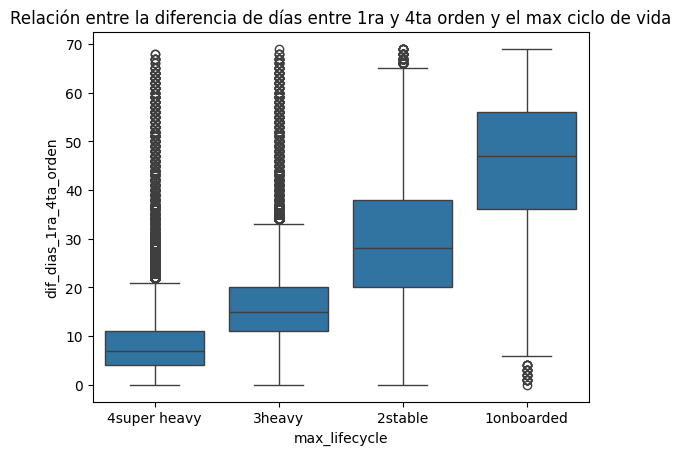

In [ ]:
############ B) BOXPLOT Relación entre el Tiempo Transcurrido entre Órdenes (Frecuencia de Compra) y max_lifecycle ########################
sns.boxplot(x='max_lifecycle', y='dif_dias_1ra_4ta_orden', data=df)
plt.title('Relación entre la diferencia de días entre 1ra y 4ta orden y el max ciclo de vida')
plt.show()

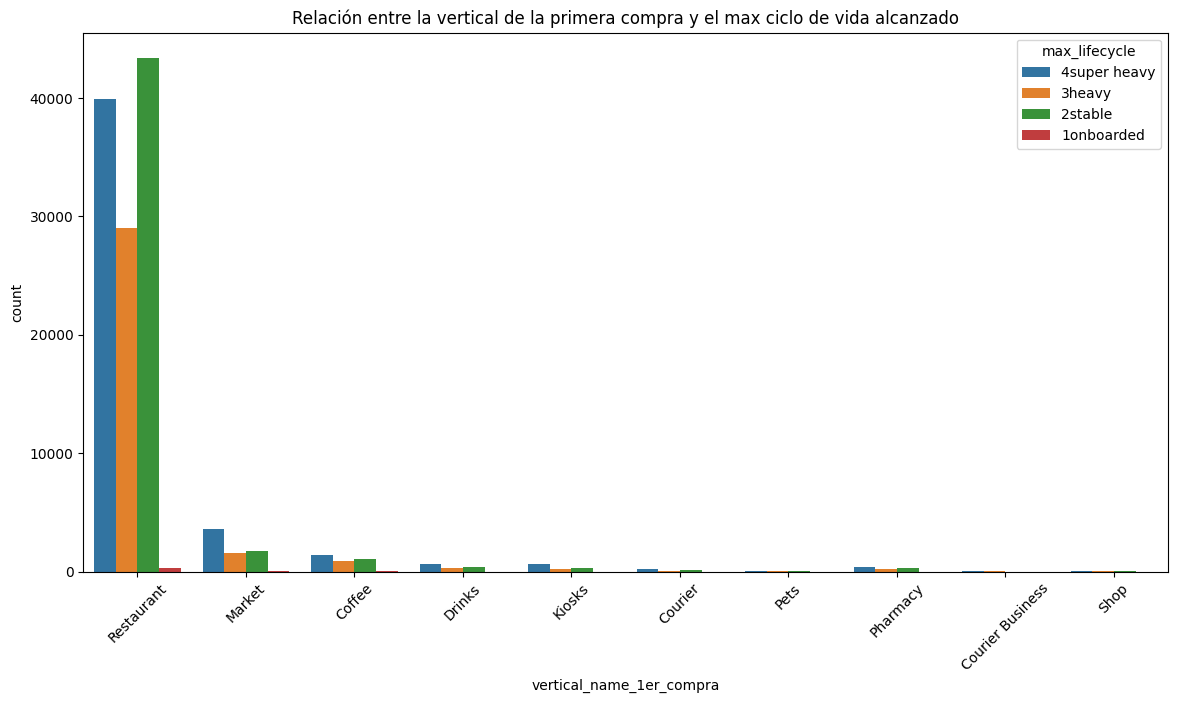

In [ ]:
############ C.1) GRAFICO DE BARRAS Relación entre la Vertical de la Primera Compra y `max_lifecycle`: ########################
plt.figure(figsize=(14, 7))
sns.countplot(x='vertical_name_1er_compra', hue='max_lifecycle', data=df)
plt.title('Relación entre la vertical de la primera compra y el max ciclo de vida alcanzado')
plt.xticks(rotation=45)
plt.show()

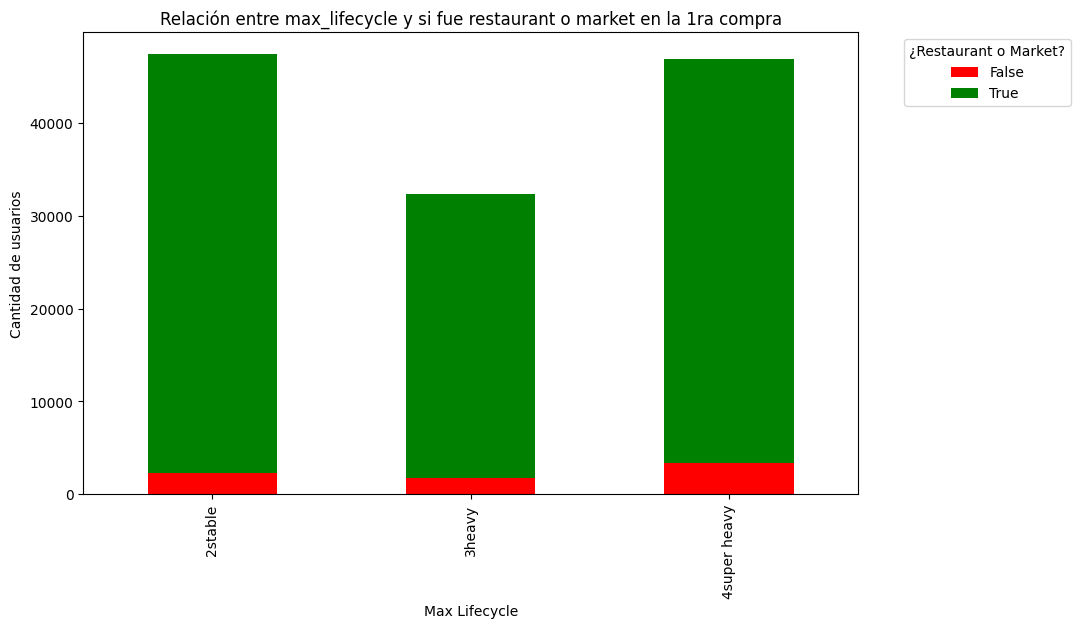

In [ ]:
############ C.2) GRAFICO DE BARRAS APILADAS Relación entre is_restaurant_or_market_1ra y `max_lifecycle`: ########################
df_filtered = df[df['max_lifecycle'] != '1onboarded'] # Filtrar el dataframe para excluir '1onboarded'

crosstab = pd.crosstab(df_filtered['max_lifecycle'], df_filtered['is_restaurant_or_market_1ra'])

crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green'])

plt.title('Relación entre max_lifecycle y si fue restaurant o market en la 1ra compra')
plt.xlabel('Max Lifecycle')
plt.ylabel('Cantidad de usuarios')
plt.legend(title='¿Restaurant o Market?', labels=['False', 'True'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<ipython-input-14-8127295ea51d>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(crosstab_percentage, annot=crosstab_percentage.applymap(lambda v: f'{v:.0f}%'), cmap="YlGnBu", fmt="")


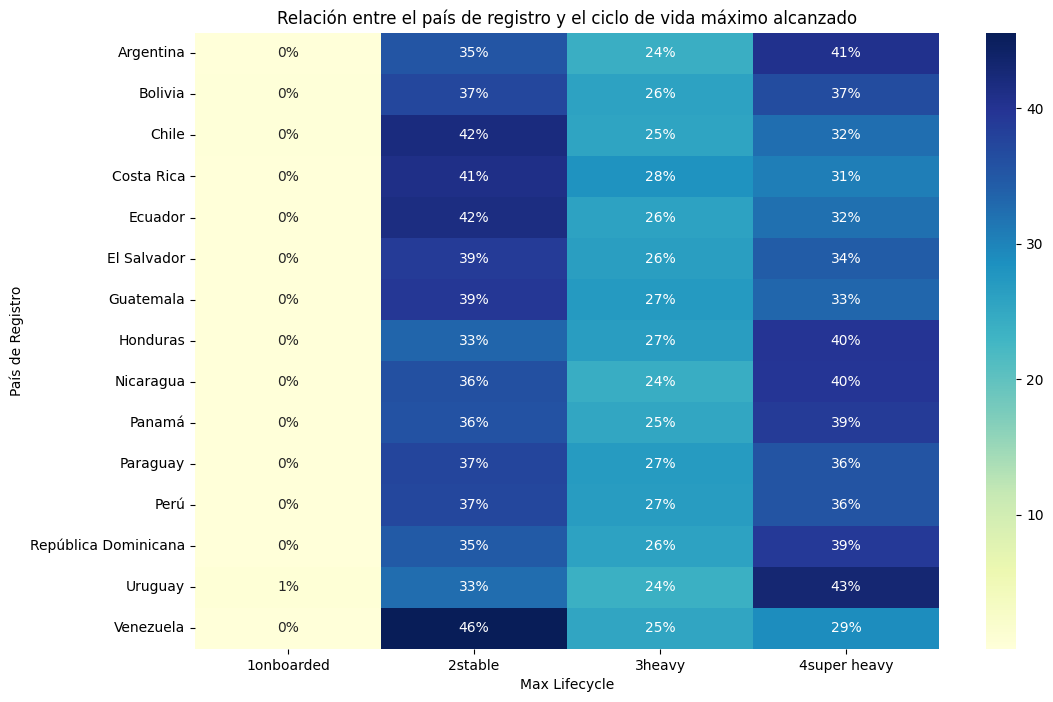

In [ ]:
############ D) HEATMAP Relación entre el País de Registro y max_lifecycle ########################
crosstab_percentage = pd.crosstab(df['pais_registro_user'], df['max_lifecycle'], normalize='index') * 100

plt.figure(figsize=(12, 8))
sns.heatmap(crosstab_percentage, annot=crosstab_percentage.applymap(lambda v: f'{v:.0f}%'), cmap="YlGnBu", fmt="")

plt.title('Relación entre el país de registro y el ciclo de vida máximo alcanzado')
plt.xlabel('Max Lifecycle')
plt.ylabel('País de Registro')

plt.show()

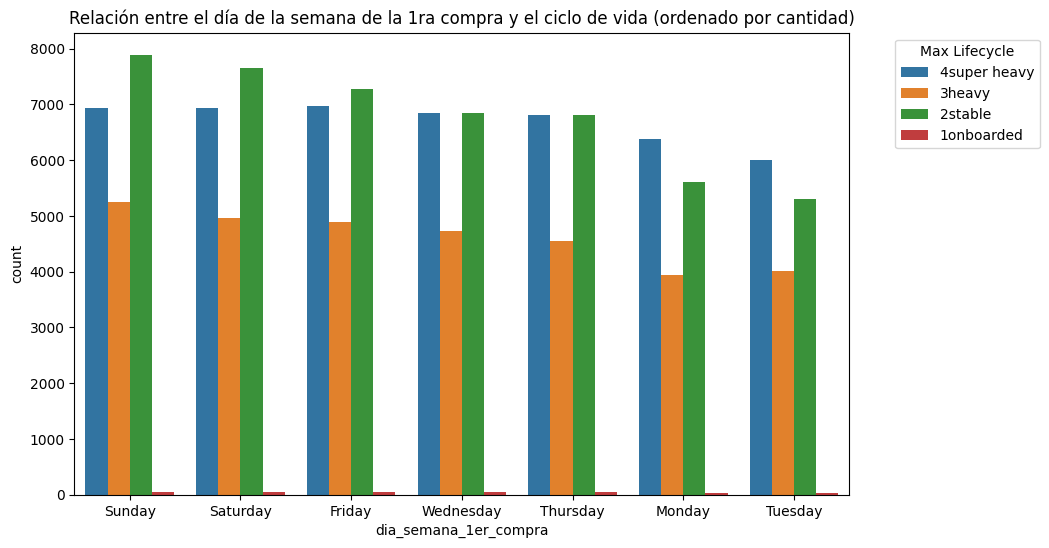

In [ ]:
############ E) GRAFICO DE BARRAS Relación entre el Día de la Semana de la Primera Compra y max_lifecycle ########################
df_day_order = df.groupby('dia_semana_1er_compra').size().reset_index(name='count')

df_day_order = df_day_order.sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 6))
sns.countplot(x='dia_semana_1er_compra', hue='max_lifecycle', data=df, order=df_day_order['dia_semana_1er_compra'])

plt.legend(title='Max Lifecycle', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Relación entre el día de la semana de la 1ra compra y el ciclo de vida (ordenado por cantidad)')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

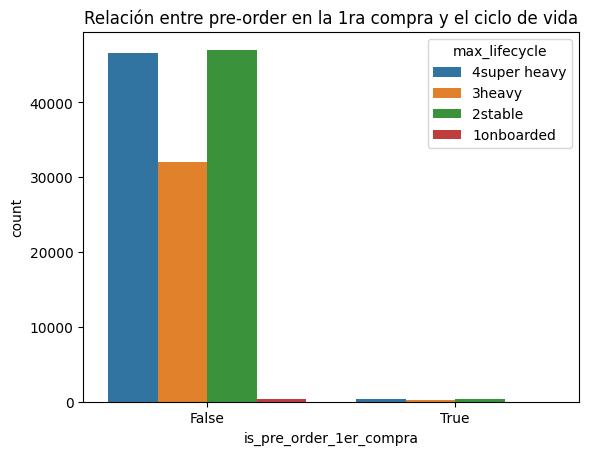

In [ ]:
############ F) GRAFICO DE BARRAS Relación entre el Uso de Pre-Orders en la Primera Compra y `max_lifecycle` ########################
sns.countplot(x='is_pre_order_1er_compra', hue='max_lifecycle', data=df)
plt.title('Relación entre pre-order en la 1ra compra y el ciclo de vida')
plt.show

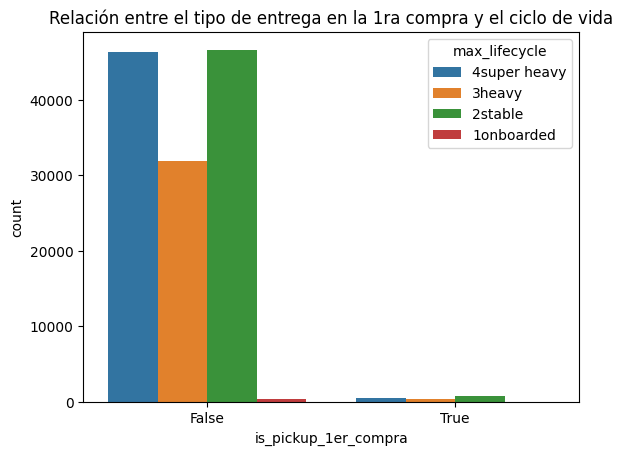

In [ ]:
############ G) GRAFICO DE BARRAS  Relación entre el Tipo de Entrega de la Primera Compra (Pickup vs. Delivery) y `max_lifecycle` ########################
sns.countplot(x='is_pickup_1er_compra', hue='max_lifecycle', data=df)
plt.title('Relación entre el tipo de entrega en la 1ra compra y el ciclo de vida')
plt.show()

In [ ]:
# H) Cuadro de resultados con el promedio de ordenes (variable para el feature engineering luego)

# Convertir las columnas de fecha a tipo datetime para calcular diferencias de días
df['dia_1er_compra'] = pd.to_datetime(df['dia_1er_compra'])
df['dia_2da_compra'] = pd.to_datetime(df['dia_2da_compra'])
df['dia_3ra_compra'] = pd.to_datetime(df['dia_3ra_compra'])
df['dia_4ta_compra'] = pd.to_datetime(df['dia_4ta_compra'])

# calculo diferencias entre cada par de órdenes
df['dif_1er_2da'] = df['dia_2da_compra'] - df['dia_1er_compra']
df['dif_2da_3ra'] = df['dia_3ra_compra'] - df['dia_2da_compra']
df['dif_3ra_4ta'] = df['dia_4ta_compra'] - df['dia_3ra_compra']

df['avg_days_between_orders'] = (df['dif_1er_2da'] + df['dif_2da_3ra'] + df['dif_3ra_4ta']) / 3

df['avg_days_between_orders'] = df['avg_days_between_orders'].dt.total_seconds() / (24 * 3600)

avg_days_per_segment = df.groupby('max_lifecycle')['avg_days_between_orders'].mean()

avg_days_per_segment

,avg_days_between_orders
max_lifecycle,
1onboarded,14.280093
2stable,9.726347
3heavy,5.506291
4super heavy,2.947519


In [ ]:
## Preprocesamiento de datos
# Convertir fechas a tipo datetime
df['dia_max_segmento_alcanzado'] = pd.to_datetime(df['dia_max_segmento_alcanzado'])

# Crear nuevas características a partir de las fechas
df['year_1er_compra'] = df['dia_1er_compra'].dt.year
df['month_1er_compra'] = df['dia_1er_compra'].dt.month
df['day_1er_compra'] = df['dia_1er_compra'].dt.day

df['year_2da_compra'] = df['dia_2da_compra'].dt.year
df['month_2da_compra'] = df['dia_2da_compra'].dt.month
df['day_2da_compra'] = df['dia_2da_compra'].dt.day

df['year_3ra_compra'] = df['dia_3ra_compra'].dt.year
df['month_3ra_compra'] = df['dia_3ra_compra'].dt.month
df['day_3ra_compra'] = df['dia_3ra_compra'].dt.day

df['year_4ta_compra'] = df['dia_4ta_compra'].dt.year
df['month_4ta_compra'] = df['dia_4ta_compra'].dt.month
df['day_4ta_compra'] = df['dia_4ta_compra'].dt.day

df['year_max_segmento'] = df['dia_max_segmento_alcanzado'].dt.year
df['month_max_segmento'] = df['dia_max_segmento_alcanzado'].dt.month
df['day_max_segmento'] = df['dia_max_segmento_alcanzado'].dt.day



max_lifecycle  1onboarded  2stable  3heavy  4super heavy
year_month                                              
2024-01                 9       64    2240          9285
2024-02                35    11643   15486         20778
2024-03                17    25427   11903         13025
2024-04                 1     7923    1781          2395
2024-05               187     2224     832          1272


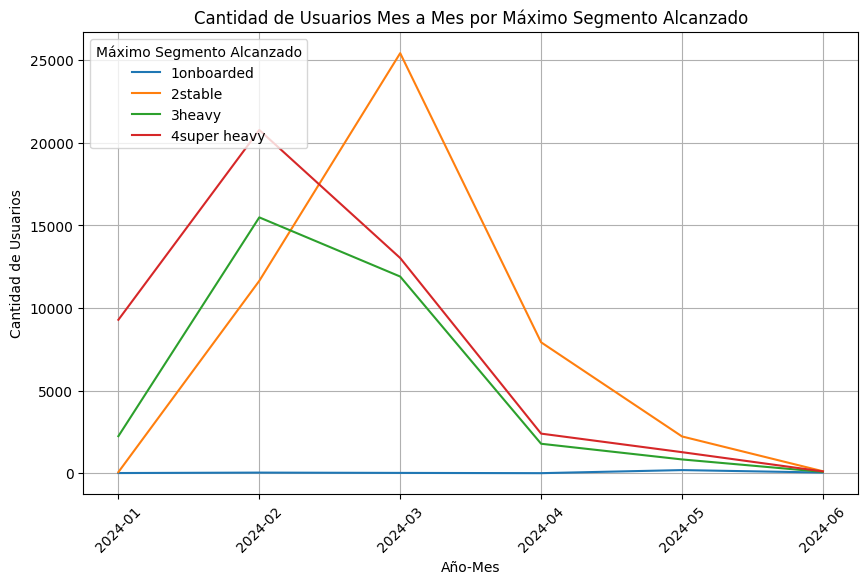

In [ ]:
# I) grafico de lineas para ver la cantidad de usuarios por segmento maximo alcanzado mes a mes
usuarios_por_mes = df.groupby(['year_max_segmento', 'month_max_segmento', 'max_lifecycle'])['user_id'].nunique().reset_index()
usuarios_por_mes['year_month'] = usuarios_por_mes['year_max_segmento'].astype(str) + '-' + usuarios_por_mes['month_max_segmento'].astype(str).str.zfill(2)

usuarios_por_mes.rename(columns={'user_id': 'cantidad_usuarios'}, inplace=True)

usuarios_por_mes_pivot = usuarios_por_mes.pivot(index='year_month', columns='max_lifecycle', values='cantidad_usuarios')

usuarios_por_mes_pivot = usuarios_por_mes_pivot.fillna(0) # Relleno valores NaN con 0 (en caso de que no haya usuarios en algún mes para ciertos segmentos)

print(usuarios_por_mes_pivot.head())

usuarios_por_mes_pivot.plot(kind='line', figsize=(10, 6))

plt.title('Cantidad de Usuarios Mes a Mes por Máximo Segmento Alcanzado')
plt.xlabel('Año-Mes')
plt.ylabel('Cantidad de Usuarios')
plt.xticks(rotation=45)
plt.legend(title='Máximo Segmento Alcanzado', loc='upper left')

plt.grid(True)
plt.show()

In [ ]:
df = df.drop(columns=['dia_1er_compra', 'dia_2da_compra', 'dia_3ra_compra', 'dia_4ta_compra', 'dia_max_segmento_alcanzado']) # estas ya las dropeo de mi dataset y uso lo de arriba

In [ ]:
###################### 4. FEATURE ENGINEERING  #############################################
# hecho en la query tengo
# A) dif_dias_1ra_4ta_orden
# B) dif_dias_4ta_orden_a_hoy
# C) dif_dias_4ta_orden_a_max_seg
# D) dif_dias_1er_orden_a_max_seg
# E) avg_days_per_segment
# F) log_avg_days_between_orders
df['log_avg_days_between_orders'] = np.log1p(df['avg_days_between_orders'])

# Definir columnas categóricas -> No uso dia_semana_max_segmento_alcanzado en el one hot encoding
categorical_columns = ['pais_registro_user'                            , 'dia_semana_1er_compra',
                       'vertical_name_1er_compra', 'country_1er_compra', 'dia_semana_2da_compra',
                       'vertical_name_2da_compra', 'country_2da_compra', 'dia_semana_3ra_compra',
                       'vertical_name_3ra_compra', 'country_3ra_compra', 'dia_semana_4ta_compra',
                       'vertical_name_4ta_compra', 'country_4ta_compra']

df = pd.get_dummies(df, columns=categorical_columns, drop_first=True) # Aplicar One-Hot Encoding a columnas categóricas

print(df.head())

    user_id dia_semana_max_segmento_alcanzado max_lifecycle  \
1  70591858                         Wednesday  4super heavy   
2  70592125                         Wednesday  4super heavy   
3  70604050                            Monday        3heavy   
4  70602102                          Thursday  4super heavy   
5  70613721                            Friday  4super heavy   

   is_restaurant_or_market_1ra  is_pre_order_1er_compra  is_pickup_1er_compra  \
1                         True                    False                 False   
2                         True                    False                 False   
3                         True                    False                 False   
4                         True                    False                 False   
5                        False                    False                 False   

   is_restaurant_or_market_2da  is_pre_order_2da_compra  is_pickup_2da_compra  \
1                         True                    Fal

In [ ]:
### 5. DROPEO DE COLUMNAS + PREDICCION  ###
X = df.drop(columns= ['user_id', 'max_lifecycle', 'year_max_segmento', 'month_max_segmento',
                     'day_max_segmento', 'dia_semana_max_segmento_alcanzado',
                     'dif_dias_4ta_orden_a_hoy', 'dif_dias_4ta_orden_a_max_seg',
                     'dif_dias_1er_orden_a_max_seg', 'max_lifecycle_label'])

##########################################################################################################
############ MULTICOLINEALIDAD

############ VIF ###########
# # Eliminar variables con baja varianza
# selector = VarianceThreshold(threshold=0.01)
# selector.fit(X)
# X_filtered = X[X.columns[selector.get_support(indices=True)]]

# # Agregar una constante (columna de 1s) al conjunto de datos
# X_with_const = sm.add_constant(X_filtered)  # Añade la constante

# # Crear un DataFrame para guardar los resultados de VIF
# vif_data = pd.DataFrame()
# vif_data["Variable"] = X_filtered.columns  # No incluir la constante aquí

# # Escalar solo las variables explicativas (sin la constante)
# scalerVIF = StandardScaler()
# X_scaled = scalerVIF.fit_transform(X_filtered)  # Solo escalar X_filtered

# # Calcular el VIF con las variables escaladas (ignorar la constante)
# vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# # Imprimir el resultado
# print("El dataframe de VIF es:", vif_data)


############ MATRIZ DE CORRELACION ###########
n_variables_per_heatmap = 20 # num_columnas / 20 => 155 / 20

# Dividir las columnas de la matriz de correlación en grupos
columns = X.columns
column_groups = [columns[i:i + n_variables_per_heatmap] for i in range(0, len(columns), n_variables_per_heatmap)]

# Crear un heatmap para cada grupo de columnas
for i, group in enumerate(column_groups):
    plt.figure(figsize=(20, 16))
    corr_matrix_group = X[group].corr()  # Sub-matriz de correlación para este grupo
    sns.heatmap(corr_matrix_group, annot=True, cmap='Reds', vmin=-1, vmax=1, center=0, fmt=".2f",
                linewidths=.5, cbar_kws={"shrink": .8})
    plt.title(f'Matriz de correlación entre las variables - Grupo {i+1}', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()  # Ajustar el layout para que todo encaje bien
    plt.show()

In [ ]:
#####################################
####### PREDICCION
y = df['max_lifecycle']

# (4super heavy > 3 heavy > 2stable > 1onboarded), voy a usar label encoder para codificar la variable objetivo
le = LabelEncoder()
y = le.fit_transform(y)
print("Clases después del LabelEncoder (serían 0, 1, 2, 3):", le.classes_)

for column in X.select_dtypes(include=['timedelta64[ns]']).columns:
    X[column] = X[column].dt.total_seconds() / (24 * 3600)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)  # Usar la misma semilla

oversampler = SMOTE(sampling_strategy={0: 3000}, random_state=11) # Aplicar sobremuestreo con SMOTE solo al conjunto de entrenamiento
X_train, y_train = oversampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos de X entrenamiento escalados en formato cantidad filas-columnas", X_train_scaled.shape)
print("Datos de X testeo escalados en formato cantidad filas-columnas", X_test_scaled.shape)

Clases después del LabelEncoder (serían 0, 1, 2, 3): ['1onboarded' '2stable' '3heavy' '4super heavy']
Datos de X entrenamiento escalados en formato cantidad filas-columnas (104266, 160)
Datos de X testeo escalados en formato cantidad filas-columnas (25374, 160)


In [ ]:
####################################################################
# Entrenamiento del 1er modelo -> N A I V E   B A Y E S
nb_model = GaussianNB()

nb_model.fit(X_train_scaled, y_train)

y_pred = nb_model.predict(X_test_scaled)

print("Accuracy Naive Bayes:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix Naive Bayes:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report Naive Bayes:\n", classification_report(y_test, y_pred))

# Accuracy Naive Bayes: 0.09856546070781115

Accuracy Naive Bayes: 0.09856546070781115

Confusion Matrix Naive Bayes:
 [[  51    6    0    5]
 [8300  587  159  525]
 [5350  205  235  636]
 [7247  165  275 1628]]

Classification Report Naive Bayes:
               precision    recall  f1-score   support

           0       0.00      0.82      0.00        62
           1       0.61      0.06      0.11      9571
           2       0.35      0.04      0.07      6426
           3       0.58      0.17      0.27      9315

    accuracy                           0.10     25374
   macro avg       0.39      0.27      0.11     25374
weighted avg       0.53      0.10      0.16     25374



In [ ]:
#####################################################################
# Entrenamiento del 2do modelo -> K  N E I G H B O R S
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print("Accuracy KNN:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix KNN:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report KNN:\n", classification_report(y_test, y_pred))

# En base a los resultados obtenidos en NV y en KNN, estos 2 serán mis modelos de baseline que compararé contra el resto de algoritmos que decida sumar
# Accuracy KNN: 0.57783557972728

Accuracy KNN: 0.57783557972728

Confusion Matrix KNN:
 [[   2   46    3   11]
 [  36 6411 1657 1467]
 [   3 2105 1912 2406]
 [  14 1274 1690 6337]]

Classification Report KNN:
               precision    recall  f1-score   support

           0       0.04      0.03      0.03        62
           1       0.65      0.67      0.66      9571
           2       0.36      0.30      0.33      6426
           3       0.62      0.68      0.65      9315

    accuracy                           0.58     25374
   macro avg       0.42      0.42      0.42     25374
weighted avg       0.57      0.58      0.57     25374



In [ ]:
####################################################################
# Entrenamiento del 3er modelo -> R E G R E S I O N  L O G I S T I C A
model_RL = LogisticRegression(max_iter=1000, random_state=11)
model_RL.fit(X_train_scaled, y_train)
y_pred = model_RL.predict(X_test_scaled)

print("Accuracy RL:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix RL:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RL:\n", classification_report(y_test, y_pred))
#Accuracy RL: 0.6894852999132971

Accuracy RL: 0.6894852999132971

Confusion Matrix RL:
 [[   0   50    1   11]
 [   7 7277 1535  752]
 [   4 1770 3096 1556]
 [   0  805 1388 7122]]

Classification Report RL:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.73      0.76      0.75      9571
           2       0.51      0.48      0.50      6426
           3       0.75      0.76      0.76      9315

    accuracy                           0.69     25374
   macro avg       0.50      0.50      0.50     25374
weighted avg       0.68      0.69      0.69     25374



In [ ]:
# Hiperparametros para el 3er modelo -> R E G R E S I O N  L O G I S T I C A    C O N   H I P E R P A R A M E T R O S
start_time = datetime.now()
print("Hora de inicio:", start_time)
# ######################################################################################################################
# ######################################################################################################################

# ######################################################################################################################################
# ######## Caso 1 |  Penalty Ridge Regularization con valores de hiperparámetros
# # =====> Hipótesis Caso 1: entender la performance de los hiperparametros si es mejor o peor que el RL sin hiperparametros. Y ver con iteraciones de mejorarla
# # param_grid = {
# #     'C': [0.001, 0.01],
# #     'solver': ['liblinear'],
# #     'penalty': ['l2'],
# #     'max_iter': [5,10]
# # }

# ###### Resultado
# # Accuracy RL con mejores hiperparámetros RL: 0.6812485221092457

# #######################################################################################################################################
# ######## Caso 2 |  Penalty Ridge Regularization con mas valores de los mismos hiperparámetros
# # =====> Hipótesis Caso 2: entender si a mayor C y a mayor max iter, performa mejor, pruebo la siguiente casuistica:
param_grid = {
    'C': [0.001, 0.01, 0.1],
    'solver': ['liblinear'],
    'penalty': ['l2'],
    'max_iter': [5,10,15]
}

# ###### Resultado
# # Accuracy RL con mejores hiperparámetros RL: 0.6843619452983368

# #######################################################################################################################################
# ######## Caso 3 |  Penalty Lasso Regularization con mismos valores de hiperparámetros C y max_iter
# # =====> Hipótesis Caso 3: entender si con Lasso puedo mejorar el accuracy obtenido en caso 2 de hiperparametros de RL
# # ya que dió mejor con estos parametros de C y de max_iter, los mantengo y vario la penalty, y por ende tambien vario el solver

# # param_grid = {
# #     'C': [0.001, 0.01, 0.1],
# #     'solver': ['liblinear','saga'],     # Uso los dos solver para Lasso
# #     'penalty': ['l1'],                  # Ahora Lasso
# #     'max_iter': [5,10,15]
# # }
# #  =====> Resultado: Debido a que no converge y que me pide incrementar el nro de iteraciones en el output que obtuve como resultado, voy a cambiar ciertos valores

# # param_grid = {
# #     'C': [0.01, 0.1, 1],       # Ajuste en los valores de C -> uso C mas grandes ya que valores pequeños de C pueden hacer que el modelo tenga dificultades para ajustar los datos
# #     'solver': ['saga'],        # Usar solo saga para Lasso (es gralmente mas adecuado y puede converger mas rapido que liblinear)
# #     'penalty': ['l1'],
# #     'max_iter': [50, 100, 150] # incremento iteraciones x10 veces en cada valor
# # }
# # =====> Resultado: Como no termina tampoco, por ende dejo 1 valor de C (el mayor que es 1), y dejo 1 iteracion y subo mucho la cantidad de max_iter

# # param_grid = {
# #     'C': [1],
# #     'solver': ['saga'],
# #     'penalty': ['l1'],
# #     'max_iter': [1000]
# # }
# # =====> Resultado: corrí asi mas de 20 minutos y no convergió con estos parametros, por ende no voy a utilizar Lasso, sino que me quedo con Ridge directo y sus variantes

# ######################################################################################################################
# ######################################################################################################################
# ######################################################################################################################
# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(LogisticRegression(random_state=11), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)
best_model_RL = grid_search.best_estimator_
y_pred = best_model_RL.predict(X_test_scaled)
# ######################################################################################################################################

end_time = datetime.now()
print("Hora de finalización:", end_time)

execution_time = end_time - start_time
print("Tiempo de ejecución:", execution_time)

print("Mejores hiperparámetros encontrados RL:", grid_search.best_params_)
print("Accuracy RL con mejores hiperparámetros RL:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix RL:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RL:\n", classification_report(y_test, y_pred))

In [ ]:
######################################################################
# Entrenamiento del 4to modelo -> R A N D O M    F O R E S T
model_RF = RandomForestClassifier(random_state=11)
model_RF.fit(X_train_scaled, y_train)
y_pred = model_RF.predict(X_test_scaled)

print("Accuracy RF:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix RF:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF:\n", classification_report(y_test, y_pred))
# Accuracy RF: 0.6708835816189801

Accuracy RF: 0.6708835816189801

Confusion Matrix RF:
 [[   0   49    2   11]
 [   1 7186 1589  795]
 [   0 1871 2917 1638]
 [   0  925 1470 6920]]

Classification Report RF:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.72      0.75      0.73      9571
           2       0.49      0.45      0.47      6426
           3       0.74      0.74      0.74      9315

    accuracy                           0.67     25374
   macro avg       0.49      0.49      0.49     25374
weighted avg       0.67      0.67      0.67     25374



In [ ]:
# Hiperparametros para el 4TO modelo -> R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   GridSearch

############################################################################################################################################
# Caso 1
# param_grid = {
#     'n_estimators':      [10],          # Número de árboles en el bosque
#     'max_depth':         [None],        # Profundidad máxima de cada árbol
#     'min_samples_split': [2],           # Muestras mínimas para dividir un nodo
#     'min_samples_leaf':  [1],           # Muestras mínimas para estar en una hoja
#     'max_features': ['auto', 'sqrt', 'log2'] # Número de características consideradas en cada división
# }

########## Resultado
# Mejores parámetros para Random Forest: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
# Accuracy RF con hiperparametros GridSearch: 0.6458579648459053


############################################################################################################################################
# Caso 2
param_grid = {
    'n_estimators': [10],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt', 0.5]  # 'sqrt' y valores numéricos para evitar errores
}

########## Resultado
# Mejores parámetros para Random Forest: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
# Accuracy RF con hiperparametros GridSearch: 0.6881453456293845

############################################################################################################################################
# Caso 3
# param_grid = {
#     'n_estimators': [30],
#     'max_depth': [50,100,150],
#     'min_samples_split': [5],
#     'min_samples_leaf': [3],
#     'max_features': ['sqrt',0.8]  # 'sqrt' y valores numéricos para evitar errores
# }

# ########## Resultado
# # Fitting 5 folds for each of 6 candidates, totalling 30 fits
# # Mejores parámetros para Random Forest: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}
# # Accuracy RF con hiperparametros GridSearch: 0.6855442579017892

# ############################################################################################################################################
# ############################################################################################################################################
# ############################################################################################################################################
model_RF = RandomForestClassifier(random_state=11)
grid_search = GridSearchCV(estimator=model_RF, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Mejores parámetros para Random Forest:", best_params)
y_pred = best_model.predict(X_test_scaled)

print("Accuracy RF con hiperparametros GridSearch:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix RF con hiperparametros GridSearch:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF con hiperparametros GridSearch:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros para Random Forest: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}
Accuracy RF con hiperparametros GridSearch: 0.6855442579017892

Confusion Matrix RF con hiperparametros GridSearch:
 [[   0   49    3   10]
 [   0 7194 1587  790]
 [   0 1725 3076 1625]
 [   1  807 1382 7125]]

Classification Report RF con hiperparametros GridSearch:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.74      0.75      0.74      9571
           2       0.51      0.48      0.49      6426
           3       0.75      0.76      0.76      9315

    accuracy                           0.69     25374
   macro avg       0.50      0.50      0.50     25374
weighted avg       0.68      0.69      0.68     25374



In [ ]:
# Hiperparametros para el 4TO modelo -> R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [50],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=11),
                                      param_distributions=param_dist_rf,
                                      n_iter=10,
                                      cv=3,
                                      scoring='accuracy',
                                      random_state=11)

random_search_rf.fit(X_train_scaled, y_train)
best_model_rf = random_search_rf.best_estimator_
y_pred = best_model_rf.predict(X_test_scaled)

print("Mejores hiperparámetros RF RandomizedSearchCV :", random_search_rf.best_params_)
print("Accuracy RF con hiperparámetros RandomizedSearchCV :", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix RF con hiperparámetros RandomizedSearchCV :\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF con hiperparámetros RandomizedSearchCV:\n", classification_report(y_test, y_pred))

# ######## Resultado
# Mejores hiperparámetros RF RandomizedSearchCV : {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}
# Accuracy RF con hiperparámetros RandomizedSearchCV : 0.689445889493182

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros RF RandomizedSearchCV : {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}
Accuracy RF con hiperparámetros RandomizedSearchCV : 0.689445889493182

Confusion Matrix RF con hiperparámetros RandomizedSearchCV :
 [[   0   49    3   10]
 [   0 7176 1585  810]
 [   0 1657 3058 1711]
 [   0  780 1275 7260]]

Classification Report RF con hiperparámetros RandomizedSearchCV:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.74      0.75      0.75      9571
           2       0.52      0.48      0.50      6426
           3       0.74      0.78      0.76      9315

    accuracy                           0.69     25374
   macro avg       0.50      0.50      0.50     25374
weighted avg       0.68      0.69      0.69     25374



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Hiperparametros para el 4TO modelo -> R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   Bayesian Optimization
param_dist_rf = {
    'n_estimators': [50],
    'max_depth': Integer(1, 10, name='max_depth'),
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True, False]
}

bayes_search_rf = BayesSearchCV(
    RandomForestClassifier(random_state=11),
    search_spaces=param_dist_rf,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    random_state=11
)

bayes_search_rf.fit(X_train_scaled, y_train)
best_model_rf = bayes_search_rf.best_estimator_
y_pred = best_model_rf.predict(X_test_scaled)

print("Mejores hiperparámetros RF Bayesian Optimization:", bayes_search_rf.best_params_)
print("Accuracy RF con Bayesian Optimization:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix RF con Bayesian Optimization:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF con Bayesian Optimization:\n", classification_report(y_test, y_pred))

############################ Resultado
# Mejores hiperparámetros RF Bayesian Optimization: OrderedDict([('bootstrap', False), ('max_depth', 9), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 50)])
# Accuracy RF con Bayesian Optimization: 0.6905099708362891


Mejores hiperparámetros RF Bayesian Optimization: OrderedDict([('bootstrap', False), ('max_depth', 9), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 50)])
Accuracy RF con Bayesian Optimization: 0.6905099708362891

Confusion Matrix RF con Bayesian Optimization:
 [[   0   49    3   10]
 [   0 7194 1558  819]
 [   0 1673 3035 1718]
 [   0  790 1233 7292]]

Classification Report RF con Bayesian Optimization:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.74      0.75      0.75      9571
           2       0.52      0.47      0.50      6426
           3       0.74      0.78      0.76      9315

    accuracy                           0.69     25374
   macro avg       0.50      0.50      0.50     25374
weighted avg       0.68      0.69      0.69     25374



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Hiperparametros para el 4TO modelo -> R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   Algoritmos Evolutivos
param_dist_rf = {
    'n_estimators': [50],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True, False]
}

tpot = TPOTClassifier(
    generations=3,
    population_size=7,
    cv=3,
    scoring='accuracy',
    random_state=11,
    verbosity=2,
    config_dict={'sklearn.ensemble.RandomForestClassifier': param_dist_rf}  # Limitar a Random Forest
)

tpot.fit(X_train_scaled, y_train)
y_pred = tpot.predict(X_test_scaled)

print("Mejor modelo RF TPOT:", tpot.fitted_pipeline_)
print("Accuracy RF con TPOT:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix RF con TPOT:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF con TPOT:\n", classification_report(y_test, y_pred))

########## Resultado
# Generation 1 - Current best internal CV score: 0.6826098430316216
# Generation 2 - Current best internal CV score: 0.6956246435370993
# Generation 3 - Current best internal CV score: 0.6956246435370993
# Best pipeline: RandomForestClassifier(RandomForestClassifier(input_matrix, bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50), bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50)
# Mejor modelo RF TPOT: Pipeline(steps=[('stackingestimator',
#                  StackingEstimator(estimator=RandomForestClassifier(bootstrap=False,
#                                                                     max_depth=10,
#                                                                     n_estimators=50,
#                                                                     random_state=11))),
#                 ('randomforestclassifier',
#                  RandomForestClassifier(max_depth=10, n_estimators=50,
#                                         random_state=11))])
# Accuracy RF con TPOT: 0.6887365019311106

Optimization Progress:   0%|          | 0/28 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6826098430316216

Generation 2 - Current best internal CV score: 0.6956246435370993

Generation 3 - Current best internal CV score: 0.6956246435370993

Best pipeline: RandomForestClassifier(RandomForestClassifier(input_matrix, bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50), bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50)
Mejor modelo RF TPOT: Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=RandomForestClassifier(bootstrap=False,
                                                                    max_depth=10,
                                                                    n_estimators=50,
                                                                    random_state=11))),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, n_estimators=50,
                               

In [ ]:
###########################################################################################################################
# Hiperparametros para el 4TO modelo -> R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   Hyperband
space = {
    'n_estimators': scope.int(hp.choice('n_estimators', [50])),
    'max_depth': hp.choice('max_depth', [None, 10]),
    'min_samples_split': scope.int(hp.choice('min_samples_split', [2])),
    'min_samples_leaf': scope.int(hp.choice('min_samples_leaf', [1])),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

def objective(params):
    rf = RandomForestClassifier(random_state=11, **params)
    score = cross_val_score(rf, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
rng = np.random.default_rng(11)
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials, rstate=rng)

best_params = space_eval(space, best)

best_rf = RandomForestClassifier(random_state=11, **best_params)
best_rf.fit(X_train_scaled, y_train)
y_pred = best_rf.predict(X_test_scaled)

print("Mejores hiperparámetros RF Hyperband:", best_params)
print("Accuracy RF con Hyperband:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix RF con Hyperband:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report RF con Hyperband:\n", classification_report(y_test, y_pred))

########## Resultado
# Mejores hiperparámetros RF Hyperband: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
# Accuracy RF con Hyperband: 0.689445889493182

100%|██████████| 10/10 [04:03<00:00, 24.31s/trial, best loss: -0.6813534409522705]
Mejores hiperparámetros RF Hyperband: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy RF con Hyperband: 0.689445889493182

Confusion Matrix RF con Hyperband:
 [[   0   49    3   10]
 [   0 7176 1585  810]
 [   0 1657 3058 1711]
 [   0  780 1275 7260]]

Classification Report RF con Hyperband:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.74      0.75      0.75      9571
           2       0.52      0.48      0.50      6426
           3       0.74      0.78      0.76      9315

    accuracy                           0.69     25374
   macro avg       0.50      0.50      0.50     25374
weighted avg       0.68      0.69      0.69     25374



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Hiperparametros para el 4TO modelo -> R A N D O M  F O R E S T    C O N   H I P E R P A R A M E T R O S   AutoML
# => Decido descartarlo por problemas con el modulo de ray tune

# param_dist_rf = {
#     'n_estimators': tune.choice([50]),
#     'max_depth': tune.choice([None, 10]),
#     'min_samples_split': tune.choice([2]),
#     'min_samples_leaf': tune.choice([1]),
#     'bootstrap': tune.choice([True, False])
# }

# # Configurar y ejecutar TuneSearchCV
# tune_search_rf = TuneSearchCV(
#     RandomForestClassifier(random_state=11),
#     param_distributions=param_dist_rf,
#     n_trials=10,           # Número de combinaciones a probar
#     scoring='accuracy',
#     cv=3,                  # Cross-validation de 3 pliegues
#     random_state=11
# )

# # Entrenar con AutoML (Tune)
# tune_search_rf.fit(X_train_scaled, y_train)

# # Obtener el mejor modelo y hacer predicciones
# best_model_rf = tune_search_rf.best_estimator_
# y_pred = best_model_rf.predict(X_test_scaled)

# # Evaluación del rendimiento del modelo
# print("Mejores hiperparámetros RF Ray Tune AutoML:", tune_search_rf.best_params_)
# print("Accuracy RF con Ray Tune AutoML:", accuracy_score(y_test, y_pred))
# print("\nConfusion Matrix RF con Ray Tune AutoML:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report RF con Ray Tune AutoML:\n", classification_report(y_test, y_pred))

In [ ]:
####################################################################
# Entrenamiento del 5to modelo -> X G B O O S T
model_XGB = xgb.XGBClassifier(random_state=11)
model_XGB.fit(X_train_scaled, y_train)
y_pred = model_XGB.predict(X_test_scaled)

print("Accuracy XGB:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix XGB:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report XGB:\n", classification_report(y_test, y_pred))

# Resultado
# Accuracy XGB: 0.6891306061322614

Accuracy XGB: 0.6891306061322614

Confusion Matrix XGB:
 [[   0   49    2   11]
 [   0 7198 1605  768]
 [   0 1666 3152 1608]
 [   2  766 1411 7136]]

Classification Report XGB:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.74      0.75      0.75      9571
           2       0.51      0.49      0.50      6426
           3       0.75      0.77      0.76      9315

    accuracy                           0.69     25374
   macro avg       0.50      0.50      0.50     25374
weighted avg       0.68      0.69      0.69     25374



In [ ]:
# Hiperparametros para el 5TO modelo ->  X G B O O S T   C O N   H I P E R P A R A M E T R O S  GRIDSEARCH
param_grid_xgb = {
    'n_estimators': [50],
    'max_depth': [3, 6],
    'learning_rate': [0.01],
    'subsample': [0.6],
    'colsample_bytree': [0.6]
}

grid_search_xgb = GridSearchCV(
    XGBClassifier(random_state=11),
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=3
)

grid_search_xgb.fit(X_train_scaled, y_train)
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test_scaled)

print("Mejores hiperparámetros XGBoost GridSearchCV:", grid_search_xgb.best_params_)
print("Accuracy XGBoost con hiperparámetros GridSearchCV:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix XGBoost con hiperparámetros GridSearchCV:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report XGBoost con hiperparámetros GridSearchCV:\n", classification_report(y_test, y_pred_xgb))

######## Resultados
# Mejores hiperparámetros XGBoost GridSearchCV: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.6}
# Accuracy XGBoost con hiperparámetros GridSearchCV: 0.6895247103334121

Mejores hiperparámetros XGBoost GridSearchCV: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.6}
Accuracy XGBoost con hiperparámetros GridSearchCV: 0.6895247103334121

Confusion Matrix XGBoost con hiperparámetros GridSearchCV:
 [[   0   49    3   10]
 [   3 7265 1512  791]
 [   0 1731 3016 1679]
 [   1  809 1290 7215]]

Classification Report XGBoost con hiperparámetros GridSearchCV:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.74      0.76      0.75      9571
           2       0.52      0.47      0.49      6426
           3       0.74      0.77      0.76      9315

    accuracy                           0.69     25374
   macro avg       0.50      0.50      0.50     25374
weighted avg       0.68      0.69      0.69     25374



In [ ]:
# Hiperparametros para el 5TO modelo ->  X G B O O S T   C O N   H I P E R P A R A M E T R O S  RandomizedSearchCV
param_dist_xgb = {
    'n_estimators': [50, 75],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

random_search_xgb = RandomizedSearchCV(
    XGBClassifier(random_state=11),
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=11
)

random_search_xgb.fit(X_train_scaled, y_train)
best_model_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test_scaled)

print("Mejores hiperparámetros XGBoost RandomizedSearchCV:", random_search_xgb.best_params_)
print("Accuracy XGBoost con hiperparámetros RandomizedSearchCV:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix XGBoost con hiperparámetros RandomizedSearchCV:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report XGBoost con hiperparámetros RandomizedSearchCV:\n", classification_report(y_test, y_pred_xgb))

######### Resultado
# Mejores hiperparámetros XGBoost RandomizedSearchCV: {'subsample': 0.6, 'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
# Accuracy XGBoost con hiperparámetros RandomizedSearchCV: 0.691455820919051

Mejores hiperparámetros XGBoost RandomizedSearchCV: {'subsample': 0.6, 'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy XGBoost con hiperparámetros RandomizedSearchCV: 0.691455820919051

Confusion Matrix XGBoost con hiperparámetros RandomizedSearchCV:
 [[   0   49    3   10]
 [   0 7212 1600  759]
 [   0 1658 3173 1595]
 [   0  762 1393 7160]]

Classification Report XGBoost con hiperparámetros RandomizedSearchCV:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.74      0.75      0.75      9571
           2       0.51      0.49      0.50      6426
           3       0.75      0.77      0.76      9315

    accuracy                           0.69     25374
   macro avg       0.50      0.50      0.50     25374
weighted avg       0.69      0.69      0.69     25374



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Hiperparametros para el 5TO modelo ->  X G B O O S T   C O N   H I P E R P A R A M E T R O S  BayesSearchCV
param_space_xgb = {
    'n_estimators': [50],
    'max_depth': Integer(3, 6),
    'learning_rate': Real(0.01, 0.1, 'log-uniform'),
    'subsample': Real(0.6, 0.8, 'uniform'),
    'colsample_bytree': Real(0.6, 0.8, 'uniform')
}

bayes_search_xgb = BayesSearchCV(
    XGBClassifier(random_state=11),
    search_spaces=param_space_xgb,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    random_state=11
)

bayes_search_xgb.fit(X_train_scaled, y_train)
best_model_xgb = bayes_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test_scaled)

print("Mejores hiperparámetros XGBoost BayesSearchCV:", bayes_search_xgb.best_params_)
print("Accuracy XGBoost con hiperparámetros BayesSearchCV:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix XGBoost con hiperparámetros BayesSearchCV:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report XGBoost con hiperparámetros BayesSearchCV:\n", classification_report(y_test, y_pred_xgb))

############## Resultado
# Mejores hiperparámetros XGBoost BayesSearchCV: OrderedDict([('colsample_bytree', 0.794120328024815), ('learning_rate', 0.08153206902545551), ('max_depth', 5), ('n_estimators', 50), ('subsample', 0.7617288693981793)])
# Accuracy XGBoost con hiperparámetros BayesSearchCV: 0.6913375896587057

Mejores hiperparámetros XGBoost BayesSearchCV: OrderedDict([('colsample_bytree', 0.794120328024815), ('learning_rate', 0.08153206902545551), ('max_depth', 5), ('n_estimators', 50), ('subsample', 0.7617288693981793)])
Accuracy XGBoost con hiperparámetros BayesSearchCV: 0.6913375896587057

Confusion Matrix XGBoost con hiperparámetros BayesSearchCV:
 [[   0   49    3   10]
 [   0 7247 1568  756]
 [   0 1703 3153 1570]
 [   0  803 1370 7142]]

Classification Report XGBoost con hiperparámetros BayesSearchCV:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.74      0.76      0.75      9571
           2       0.52      0.49      0.50      6426
           3       0.75      0.77      0.76      9315

    accuracy                           0.69     25374
   macro avg       0.50      0.50      0.50     25374
weighted avg       0.69      0.69      0.69     25374



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Hiperparametros para el 5TO modelo ->  X G B O O S T   C O N   H I P E R P A R A M E T R O S  TPOTClassifier
tpot = TPOTClassifier(
    generations=2,
    population_size=3,
    verbosity=2,
    random_state=11,
    config_dict='TPOT sparse'
)

tpot.fit(X_train_scaled, y_train)
best_model_xgb = tpot.fitted_pipeline_
y_pred_xgb = tpot.predict(X_test_scaled)

print("Accuracy XGBoost con TPOT:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix XGBoost con TPOT:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report XGBoost con TPOT:\n", classification_report(y_test, y_pred_xgb))

######### Resultado
# Generation 1 - Current best internal CV score: 0.6933900380202783
# Generation 2 - Current best internal CV score: 0.6973702687135771
# Best pipeline: XGBClassifier(input_matrix, learning_rate=1.0, max_depth=2, min_child_weight=2, n_estimators=100, n_jobs=1, subsample=0.55, verbosity=0)
# Accuracy XGBoost con TPOT: 0.6900370457949082

Optimization Progress:   0%|          | 0/9 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6933900380202783

Generation 2 - Current best internal CV score: 0.6973702687135771

Best pipeline: XGBClassifier(input_matrix, learning_rate=1.0, max_depth=2, min_child_weight=2, n_estimators=100, n_jobs=1, subsample=0.55, verbosity=0)
Accuracy XGBoost con TPOT: 0.6900370457949082

Confusion Matrix XGBoost con TPOT:
 [[   0   49    3   10]
 [   6 7154 1656  755]
 [   1 1629 3218 1578]
 [   0  767 1411 7137]]

Classification Report XGBoost con TPOT:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.75      0.75      0.75      9571
           2       0.51      0.50      0.51      6426
           3       0.75      0.77      0.76      9315

    accuracy                           0.69     25374
   macro avg       0.50      0.50      0.50     25374
weighted avg       0.69      0.69      0.69     25374



In [ ]:
# Hiperparametros para el 5TO modelo ->  X G B O O S T   C O N   H I P E R P A R A M E T R O S   AutoML (con AutoGluon)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

y_train = pd.Series(y_train, name='target')
y_test = pd.Series(y_test, name='target')

train_data = pd.concat([X_train_scaled, y_train], axis=1)
train_data.columns = list(X_train_scaled.columns) + ['target']
test_data = pd.concat([X_test_scaled, y_test], axis=1)
test_data.columns = list(X_test_scaled.columns) + ['target']

predictor = TabularPredictor(label='target', eval_metric='accuracy').fit(train_data)
y_pred_xgb = predictor.predict(test_data.drop(columns=['target']))

print("Accuracy XGBoost con AutoGluon:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix XGBoost con AutoGluon:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report XGBoost con AutoGluon:\n", classification_report(y_test, y_pred_xgb))

##############
# Resultado -> Accuracy XGBoost con AutoGluon: 0.690470560416174

No path specified. Models will be saved in: "AutogluonModels/ag-20241125_205949"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.65 GB / 12.67 GB (68.2%)
Disk Space Avail:   71.58 GB / 107.72 GB (66.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fa

Accuracy XGBoost con AutoGluon: 0.690470560416174

Confusion Matrix XGBoost con AutoGluon:
 [[   0   50    2   10]
 [   2 7287 1532  750]
 [   0 1744 3093 1589]
 [   1  793 1381 7140]]

Classification Report XGBoost con AutoGluon:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.74      0.76      0.75      9571
           2       0.51      0.48      0.50      6426
           3       0.75      0.77      0.76      9315

    accuracy                           0.69     25374
   macro avg       0.50      0.50      0.50     25374
weighted avg       0.68      0.69      0.69     25374



In [ ]:
# Hiperparametros para el 5TO modelo ->  X G B O O S T   C O N   H I P E R P A R A M E T R O S  TuneSearchCV
# => decido no usarlo porque tiene los mismos problemas de librerias que RandomForest que no ejecuta

# Definir el espacio de búsqueda
# param_dist_xgb = {
#     'n_estimators': tune.choice([50, 100]),
#     'max_depth': tune.choice([3, 6, 10]),
#     'learning_rate': tune.choice([0.01, 0.1]),
#     'subsample': tune.choice([0.6, 0.8]),
#     'colsample_bytree': tune.choice([0.6, 0.8])
# }

# # Configurar y ejecutar la búsqueda
# tune_search_xgb = TuneSearchCV(
#     XGBClassifier(random_state=11),
#     param_distributions=param_dist_xgb,
#     n_trials=10,   # Número de combinaciones a probar
#     scoring='accuracy',
#     cv=3
# )

# # Entrenar con TuneSearchCV
# tune_search_xgb.fit(X_train_scaled, y_train)

# # Obtener el mejor modelo
# best_model_xgb = tune_search_xgb.best_estimator_

# # Predicción con el mejor modelo en el conjunto de test
# y_pred_xgb = best_model_xgb.predict(X_test_scaled)

# # Evaluación del rendimiento del modelo
# print("Mejores hiperparámetros XGBoost TuneSearchCV:", tune_search_xgb.best_params_)
# print("Accuracy XGBoost con hiperparámetros TuneSearchCV:", accuracy_score(y_test, y_pred_xgb))
# print("\nConfusion Matrix XGBoost con hiperparámetros TuneSearchCV:\n", confusion_matrix(y_test, y_pred_xgb))
# print("\nClassification Report XGBoost con hiperparámetros TuneSearchCV:\n", classification_report(y_test, y_pred_xgb))